In [36]:
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brian2.only import *
import brian2

%load_ext autoreload
%autoreload 1

%aimport numpy_
%aimport spatial
%aimport model
%aimport inputs
%aimport util
%aimport spike_utils

# for the IDE:
import numpy_ as np
import spatial, model, inputs

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rng = np.random.default_rng()
set_device('cpp_standalone')
prefs.devices.cpp_standalone.openmp_threads = mp.cpu_count() - 2

In [3]:
N = 1000
inhibitory_ratio = .2

params = {
    # Simulation
    'dt': 1*ms,
    
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    'voltage_init': 'v_rest',
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': np.log(1),
    'w_inh_sigma': 0.2,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 30,
    'w_exc_mean': np.log(1.5),
    'w_exc_sigma': 0.2,

    # Stimulus
    'N_stimuli': 5,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 5,
    'sequence_count': 20,
    'fully_random_msc': True,
    'ISI': 500*ms,
}

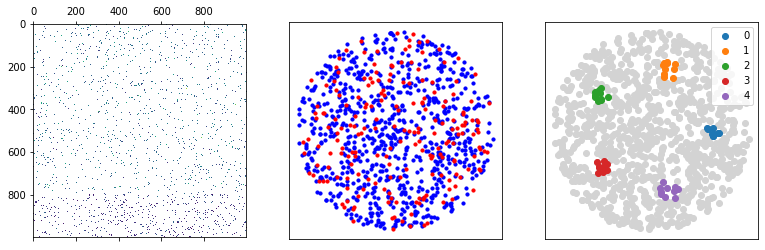

In [4]:
# X, Y, W, D = spatial.create_weights(params, rng)
f = np.load('overlap_5.npz')
X, Y, W, D, A, B = f['X']*meter, f['Y']*meter, f['W'], f['D'], f['A'], f['B']
Xstim, Ystim = spatial.create_stimulus_locations(params)

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs[0].matshow(W)
axs[1].scatter(X[:params['N_exc']], Y[:params['N_exc']], s=10, c='b')
axs[1].scatter(X[params['N_exc']:], Y[params['N_exc']:], s=10, c='r')

idx = spatial.get_stimulated(X, Y, Xstim, Ystim, params)
axs[2].scatter(X, Y, c='lightgrey')
for i, row in enumerate(idx):
    axs[2].scatter(X[row], Y[row], label=i)
axs[2].legend()

for ax in axs[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
def raster(net):
    fig, ax = plt.subplots(figsize=(20,5))
    offset = 0
    ticks, mticks, labels = [], [], []
    for k in ['Exc', 'Inh']:
        plt.plot(net[f'SpikeMon_{k}'].t/second, net[f'SpikeMon_{k}'].i + offset, ',k')
        ticks.append(offset)
        mticks.append(offset+net[k].N/2)
        labels.append(k)
        offset += net[k].N
        print(k, len(net[f'SpikeMon_{k}'].i)/net.t/net[k].N)
    ticks.append(offset)
    ax.set_yticks(ticks)
    ax.set_yticks(mticks, minor=True)
    ax.set_yticklabels(labels, minor=True)
    ax.set_xlabel('seconds')
    return ax

In [272]:
def get_episode_spikes(Net, params, episode=0, sorted=True, with_xr=False):
    offset = 0
    T, I = [], []
    episode_duration = params['ISI']*params['sequence_length']*params['sequence_count']
    full_episode_duration = params['settling_period'] + episode_duration
    t0 = episode * full_episode_duration + params['settling_period']
    for k in ['Exc', 'Inh']:
        t, i = Net[f'SpikeMon_{k}'].t, Net[f'SpikeMon_{k}'].i + offset
        offset += Net[k].N
        mask = (t >= t0 - 0.5*params['dt']) & (t < t0 + episode_duration - 0.5*params['dt'])
        T.append(t[mask])
        I.append(i[mask])
    T = np.concatenate(T) - t0
    I = np.concatenate(I)
    if sorted:
        sorted = np.argsort(T)
        T, I = T[sorted], I[sorted]
    
    if with_xr and 'StateMon_Exc' in Net:
        i0 = int(t0/params['dt'] + 0.5)
        try:
            if isinstance(get_device(), brian2genn.device.GeNNDevice):
                i0 -= 1
        except NameError:
            pass
        iend = i0 + int(episode_duration/params['dt'] + 0.5)
        iT = (T/params['dt'] + 0.5).astype(int)
        xr_rec = Net['StateMon_Exc'].synaptic_xr[:, i0:iend]
        xr = np.ones(I.shape)
        Imask = I < params['N_exc']
        xr[Imask] = xr_rec[I[Imask], iT[Imask]]
    else:
        xr = None
    return I, T, xr

In [273]:
def get_neuron_spike_counts(N, pulsed_i, sequence, target_item):
    numspikes = np.zeros(N, dtype=int)
    for pulse_idx, pulse_item in enumerate(sequence):
        if pulse_item == target_item:
            np.add.at(numspikes, pulsed_i[pulse_idx], 1)
    return numspikes

In [274]:
def get_pulse_spike_counts_TMP(t, ISI):
    pulse_number = t // ISI
    steps = np.flatnonzero(np.diff(pulse_number) > 0)
    internal_num_spikes = np.diff(steps)
    num_spikes = np.concatenate([[steps[0]+1], internal_num_spikes, [0]])
    num_spikes[-1] = len(t) - np.sum(num_spikes)
    return num_spikes

In [275]:
def get_pulse_spike_counts(Net, params, episode=0):
    I, T, _ = get_episode_spikes(Net, params, episode=episode)
    return get_pulse_spike_counts_TMP(T, params['ISI'])

In [372]:
def populate_spike_results(Net, params, results, episode=0):
    npulses = params['sequence_length']*params['sequence_count']
    results['nspikes'] = get_pulse_spike_counts(Net, params, episode)
    results['spike_i'], results['spike_t'], results['spike_xr'] = get_episode_spikes(Net, params, episode=episode, with_xr=True)
    results['pulsed_i'], results['pulsed_t'] = zip(*list(iterspikes(
        results['spike_i'], results['spike_t'], npulses, params['ISI'])))
    results['pulsed_nspikes'] = np.zeros((len(results['pulsed_i']), params['N']), int)
    for j, i in enumerate(results['pulsed_i']):
        np.add.at(results['pulsed_nspikes'][j], i, 1)
    if 'StateMon_Exc' in Net:
        results['pulsed_xr'] = list(map(lambda tp: tp[0], iterspikes(
            results['spike_xr'], results['spike_t'], npulses, params['ISI'])))
        tpulse = np.arange(npulses)*params['ISI'] + episode*npulses*params['ISI'] + (episode+1)*params['settling_period']
        results['pulse_onset_th_adapt'] = np.concatenate([
            Net['StateMon_Exc'].th_adapt[:, (tpulse/params['dt'] + .5).astype(int)],
            np.zeros((params['N_inh'], npulses))*volt], axis=0).T

In [341]:
def get_results(Net, params, Astd, Bstd, MSC, A, B):
    populate_spike_results(Net, params, Astd, 0)
    populate_spike_results(Net, params, Bstd, 1)
    populate_spike_results(Net, params, MSC, 2)
    all_results = {
        'A': {'stimulus': A, 'Std': Astd, 'Dev': Bstd, 'MSC': MSC},
        'B': {'stimulus': B, 'Std': Bstd, 'Dev': Astd, 'MSC': MSC},
    }
    for results_dict in all_results.values():
        for rkey in ('Std', 'Dev', 'MSC'):
            results = results_dict[rkey]
            out = results_dict[rkey.lower()] = {}
            pulse_mask = results['Seq'] == results_dict['stimulus']
            if 'StateMon_Exc' in Net:
                quant = np.asarray([quantify_presynaptic(W, params, results, i, results_dict['stimulus'])
                                    for i in range(params['N'])]).T
                for i, qkey in enumerate(('inputs_exc', 'inputs_inh', 'depression_factor')):
                    out[qkey] = quant[i]
                
                out['pulse_onset_th_adapt'] = results['pulse_onset_th_adapt'][pulse_mask]
            out['nspikes'] = results['pulsed_nspikes'][pulse_mask].mean(0)
    return all_results

In [342]:
def get_hist_and_xr(params, results, sources, neuron_idx, target_stim):
    '''
    Computes
    - the pulse-triggered spike histogram of the target neuron_idx as a (t,) ndarray
    - the pulse-triggered spike histogram of its presynaptic sources as a (sources, t) ndarray
    - the mean input delivered by each source, in (short-term depression modulated) fractional spikes, as a (sources,) ndarray.
    '''
    source_map = np.zeros(params['N'], int)
    source_map[sources] = np.arange(len(sources))

    pulse_ids = np.flatnonzero(results['Seq'] == target_stim)
    if pulse_ids[0] == 0:  # Ignore pulse 0
        pulse_ids = pulse_ids[1:]
    
    target_hist = np.zeros(int(params['ISI'] / params['dt']), int)
    source_hist = np.zeros((len(sources), len(target_hist)), int)
    source_xr = np.zeros(len(sources))
    
    for pulse in pulse_ids:
        target_spikes = results['pulsed_t'][pulse][results['pulsed_i'][pulse] == neuron_idx]
        target_hist[(target_spikes/params['dt'] + .5).astype(int)] += 1
        
        source_mask = np.isin(results['pulsed_i'][pulse], sources)
        source_indices = results['pulsed_i'][pulse][source_mask]
        source_times = results['pulsed_t'][pulse][source_mask]
        source_hist[source_map[source_indices], (source_times/params['dt'] + .5).astype(int)] += 1

        np.add.at(source_xr, source_map[source_indices], results['pulsed_xr'][pulse][source_mask])
    
    npulses = len(pulse_ids)
    return target_hist/npulses, source_hist/npulses, source_xr/npulses

In [343]:
def quantify_presynaptic(W, params, results, neuron_idx, target_stim):
    '''
    Finds:
    - The cumulative presynaptic input over STATIC weights (static_exc, static_inh: two scalars).
        In other words, the summed pulse-triggered spike histogram, weighted by static synaptic weight.
    - The factor by which static_exc is reduced due to short-term depression (depression_factor: one scalar)
    Note: "input" here refers to the increments applied to the target's synaptic conductance.
    '''
    sources = np.flatnonzero(W[:, neuron_idx] > 0)
    weights = W[sources, neuron_idx]
    exc = sources < params['N_exc']
    
    _, source_hist, source_xr = get_hist_and_xr(params, results, sources, neuron_idx, target_stim)

    static_exc = np.sum(source_hist[exc].sum(1) * weights[exc])
    static_inh = np.sum(source_hist[~exc].sum(1) * weights[~exc])
    dynamic = np.sum(source_xr[exc] * weights[exc])
    return static_exc, static_inh, dynamic/static_exc

In [344]:
def plot_events(W, params, results_dict, neuron_idx, target_stim, figsize=None):
    sources = np.flatnonzero(W[:, neuron_idx] > 0)
    weights = W[sources, neuron_idx]
    
    target_hists, source_hists, source_xrs = [], [], []
    for results in results_dict.values():
        target_hist, source_hist, source_xr = get_hist_and_xr(params, results, sources, neuron_idx, target_stim)
        target_hists.append(target_hist)
        source_hists.append(source_hist)
        source_xrs.append(source_xr)
    
    target_hists = np.asarray(target_hists)  # res, t
    source_hists = np.asarray(source_hists)  # res, sources, t
    source_xrs = np.asarray(source_xrs)  # res, sources
    tmax = max(
        np.flatnonzero(source_hists.sum(axis=(0,1)) > 0)[-1],
        np.flatnonzero(target_hists.sum(axis=0) > 0)[-1]
    )
    x = np.arange(0*ms, tmax*params['dt'], 1*msecond) / msecond
    y = np.arange(len(sources))

    
    weight_signs = np.ones(len(sources))
    weight_signs[sources >= params['N_exc']] = -1
    maxw = weights.max()
    weighted_total = np.sum(source_xrs * weights * weight_signs, axis=0)
    order = np.argsort(weighted_total)

    fig, axs = plt.subplots(len(results_dict), figsize=figsize)
    for i, (ax, key) in enumerate(zip(axs, results_dict.keys())):
        m = ax.pcolormesh(x, y, source_hists[i, order, :tmax] * weight_signs[order, None], vmin=-1, vmax=1, cmap='seismic_r')
        ax.set_ylabel(key)

        ax2 = ax.twinx()
        ax2.plot(x, target_hists[i, :tmax], 'g')
        ax2.set_ylim([0,1])

        ax3 = ax.twiny()
        ax3.plot(weights[order] * source_xrs[i, order]/source_hists[i, order].sum(1), np.arange(len(sources)), c='magenta', lw=1)
        ax3.plot(weights[order], np.arange(len(sources)), c='purple', lw=1)
        ax3.set_xlim([4*maxw, 0])
        if i == 0:
            ax3.set_xticks([maxw, maxw/2, 0])
            ax3.set_xlabel('|w|')
        else:
            ax3.set_xticks([])
    plt.colorbar(m, location='right', ax=axs, label='p(spike)')

In [345]:
def scatter_nspikes(params, std, dev, msc, target, normalise='subtractive'):
    s = std['pulsed_nspikes'][std['Seq']==target].mean(0)
    d = dev['pulsed_nspikes'][dev['Seq']==target].mean(0)
    c = msc['pulsed_nspikes'][msc['Seq']==target].mean(0)
    if 'mult' in normalise:
        s[s==0] = np.inf
        mask = s>0
        d=d[mask]/s[mask]
        c=c[mask]/s[mask]
        plt.loglog()
        normstr = '/std'
        colors = np.where(np.arange(params['N']) < params['N_exc'], np.asarray(['b']), np.asarray(['r']))
        plt.axhline(1, c='k', ls='--', lw=1)
        plt.axvline(1, c='k', ls='--', lw=1)
    elif 'sub' in normalise:
        c = c-s
        d = d-s
        normstr = '-std'
        colors = np.where(np.arange(params['N']) < params['N_exc'], np.asarray(['b']), np.asarray(['r']))
        plt.axhline(0, c='k', ls='--', lw=1)
        plt.axvline(0, c='k', ls='--', lw=1)
    else:
        normstr = ''
        colors = np.where(d > s, np.asarray(['green']), np.asarray(['purple']))
    plt.scatter(c, d, c=colors)
    xlim, ylim = plt.xlim(), plt.ylim()
    lo, hi = min(np.min(c), np.min(d)), max(np.max(c), np.max(d))
    plt.plot([lo, hi], [lo, hi], 'k--', lw=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.ylabel(f'dev{normstr}')
    plt.xlabel(f'msc{normstr}')

In [358]:
def scatter_IO(params, all_results, target, cond1, cond2):
    fig, axs = plt.subplots(1,5, figsize=(25,5))
    plt.suptitle(f'{target}, {cond1} - {cond2}')
    x = all_results[target][cond1]['nspikes'] - all_results[target][cond2]['nspikes']
    colors = np.where(np.arange(params['N']) < params['N_exc'], np.asarray(['b']), np.asarray(['r']))
    for ax, key in zip(axs, ('inputs_inh', 'inputs_exc', 'depression_factor')):
        y = all_results[target][cond1][key] - all_results[target][cond2][key]
        ax.scatter(x, y, c=colors)
        ax.set_xlabel('$\\Delta$ Output spikes per pulse')
        ax.set_ylabel(f'$\\Delta$ {key}')
        nan = np.isnan(x+y)
        ax.set_title(r'$r^2 = $' + f'{np.corrcoef(x[~nan], y[~nan])[0,1]**2:.2f}')
    
    y = (all_results[target][cond1]['inputs_exc']*all_results[target][cond1]['depression_factor']
        - all_results[target][cond2]['inputs_exc']*all_results[target][cond2]['depression_factor'])
    axs[3].scatter(x, y, c=colors)
    axs[3].set_xlabel('$\\Delta$ Output spikes per pulse')
    axs[3].set_ylabel(f'$\\Delta$ total excitatory input')
    nan = np.isnan(x+y)
    axs[3].set_title(r'$r^2 = $' + f'{np.corrcoef(x[~nan], y[~nan])[0,1]**2:.2f}')

    y = all_results[target][cond1]['pulse_onset_th_adapt'].mean(0) - all_results[target][cond2]['pulse_onset_th_adapt'].mean(0)
    exc = np.arange(params['N_exc'])
    axs[4].scatter(x[exc], y[exc]/mV, c=colors[exc])
    axs[4].set_xlabel('$\\Delta$ Output spikes per pulse')
    axs[4].set_ylabel(f'$\\Delta$ threshold adaptation (mV)')
    nan = np.isnan(x)
    axs[4].set_title(r'$r^2 = $' + f'{np.corrcoef(x[~nan], y[~nan])[0,1]**2:.2f}')
    
    for ax in axs:
        ax.axhline(0, c='k', ls='--', lw=1)
        ax.axvline(0, c='k', ls='--', lw=1)
    plt.tight_layout()

In [13]:
X, Y, W, D = spatial.create_weights(params, rng)
Xstim, Ystim = spatial.create_stimulus_locations(params)
A, B = params['N_stimuli']-1, rng.choice(params['N_stimuli']-1)
Cx = np.arange(params['N_stimuli'])
Cx[A] = Cx[B] = -1
Cx = Cx[Cx>=0]

Astd, Bstd, MSC = {}, {}, {}

device.reinit()
device.activate()
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params)
Astd['Seq'], T = inputs.create_oddball(Net, params, A, B)
Bstd['Seq'], T = inputs.create_oddball(Net, params, B, A, offset=T)
MSC['Seq'], T = inputs.create_MSC(Net, params, rng, offset=T)
Net.run(T)

WARNING    OpenMP code is not yet well tested, and may be inaccurate. [brian2.devices.cpp_standalone.device.openmp]


In [346]:
all_results = get_results(Net, params, Astd, Bstd, MSC, A, B)

WARNING    /tmp/ipykernel_887733/190629302.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return static_exc, static_inh, dynamic/static_exc
 [py.warnings]


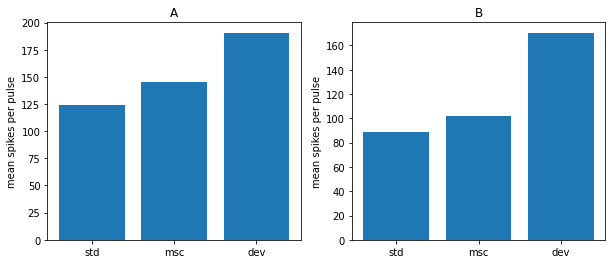

In [284]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
keys = ('std', 'msc', 'dev')
for ax, (target, results) in zip(axs, all_results.items()):
    ax.bar(keys, [results[key]['nspikes'].sum() for key in keys])
    ax.set_title(target)
    ax.set_ylabel('mean spikes per pulse')

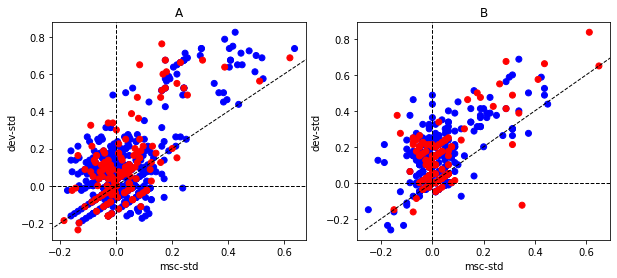

In [285]:
plt.figure(figsize=(10,4))
plt.subplot(121)
scatter_nspikes(params, Astd, Bstd, MSC, A)
plt.title('A')
plt.subplot(122)
scatter_nspikes(params, Bstd, Astd, MSC, B)
plt.title('B');

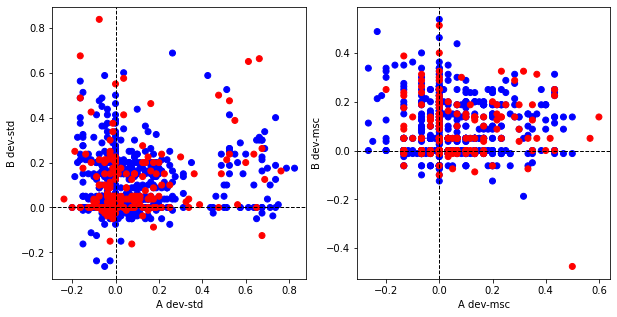

In [286]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
colors = np.where(np.arange(params['N']) < params['N_exc'], np.asarray(['b']), np.asarray(['r']))
for ax, cond in zip(axs, ('std', 'msc')):
    ax.scatter(all_results['A']['dev']['nspikes'] - all_results['A'][cond]['nspikes'], all_results['B']['dev']['nspikes'] - all_results['B'][cond]['nspikes'], c=colors)
    ax.set_xlabel(f'A dev-{cond}')
    ax.set_ylabel(f'B dev-{cond}')
    ax.axhline(0, c='k', ls='--', lw=1)
    ax.axvline(0, c='k', ls='--', lw=1)

In [ ]:
raise InterruptedError

In [301]:
fname = 'presynaptic_events.npz'

In [302]:
np.savez(fname, W=W, X=X, Y=Y, D=D, A=A, B=B)
print(f'Saved structure to {fname}')

Saved structure to presynaptic_events.npz


In [303]:
f = np.load(fname)
W, X, Y, D, A, B = [f[k] for k in 'WXYDAB']

In [19]:
device.reinit()
device.activate()
Net = model.create_network(X, Y, Xstim, Ystim, W, D, params, state_dt=params['dt'], extras=('u','xr'))
Astd['Seq'], T = inputs.create_oddball(Net, params, A, B)
Bstd['Seq'], T = inputs.create_oddball(Net, params, B, A, offset=T)
MSC['Seq'], T = inputs.create_MSC(Net, params, rng, offset=T)
Net.run(T)

In [ ]:
all_results = get_results(Net, params, Astd, Bstd, MSC, A, B)

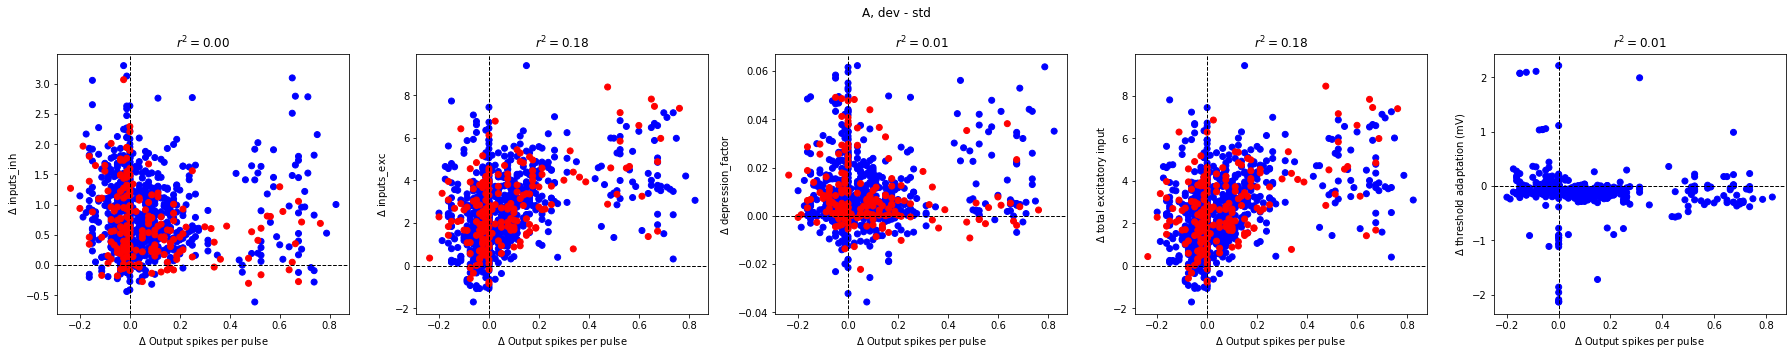

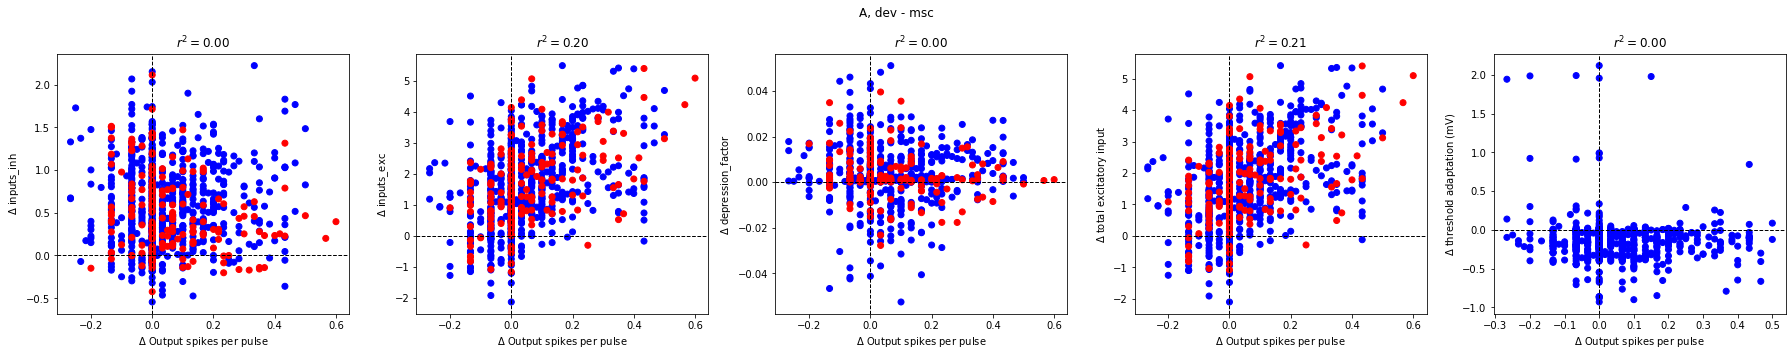

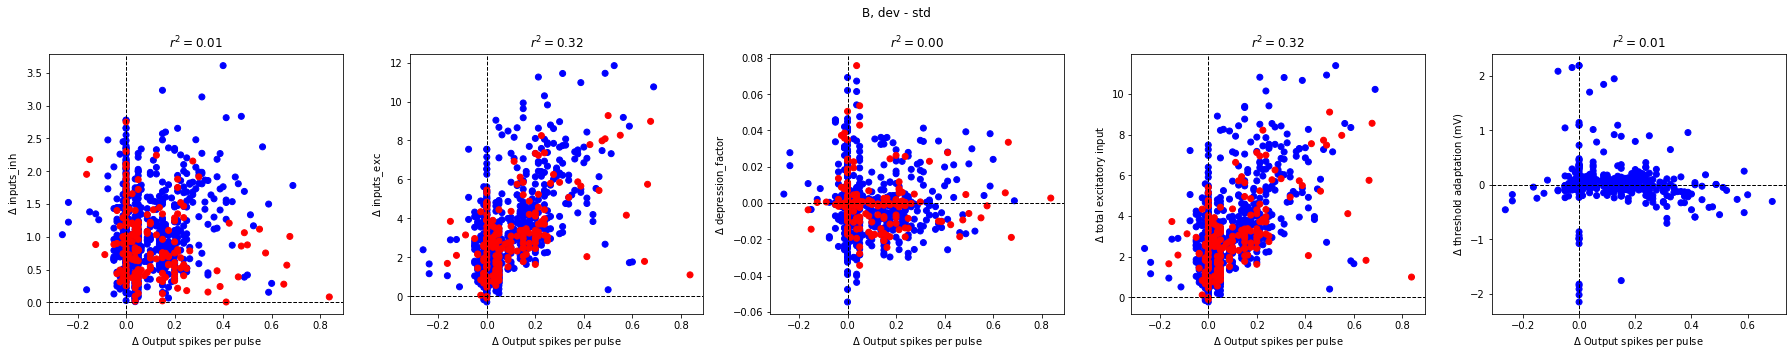

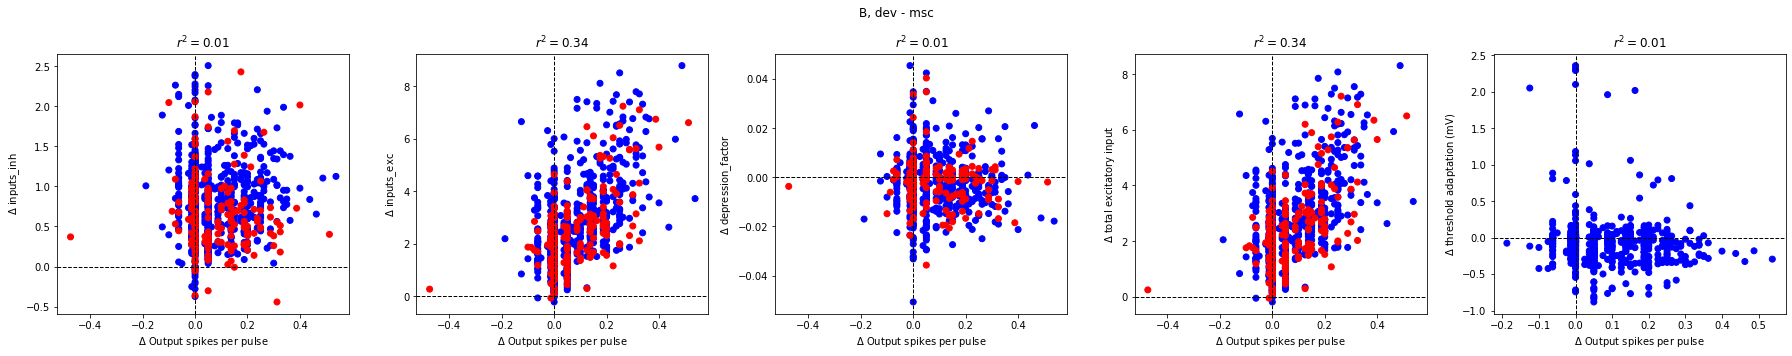

In [359]:
for target in ('A', 'B'):
    for cond2 in ('std', 'msc'):
        scatter_IO(params, all_results, target, 'dev', cond2)

WARNING    /tmp/ipykernel_887733/1522901280.py:39: RuntimeWarning: invalid value encountered in true_divide
  ax3.plot(weights[order] * source_xrs[i, order]/source_hists[i, order].sum(1), np.arange(len(sources)), c='magenta', lw=1)
 [py.warnings]


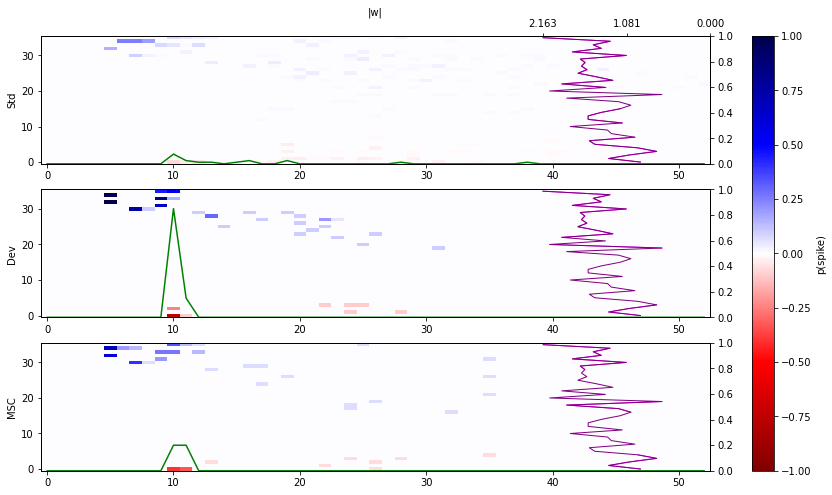

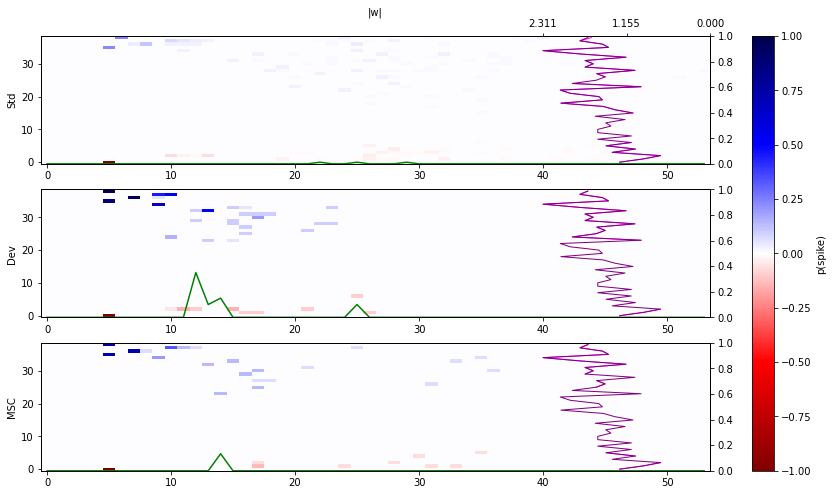

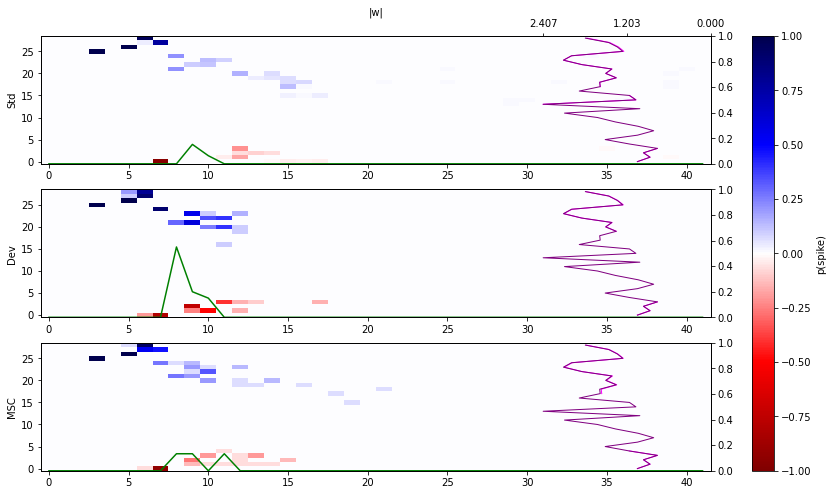

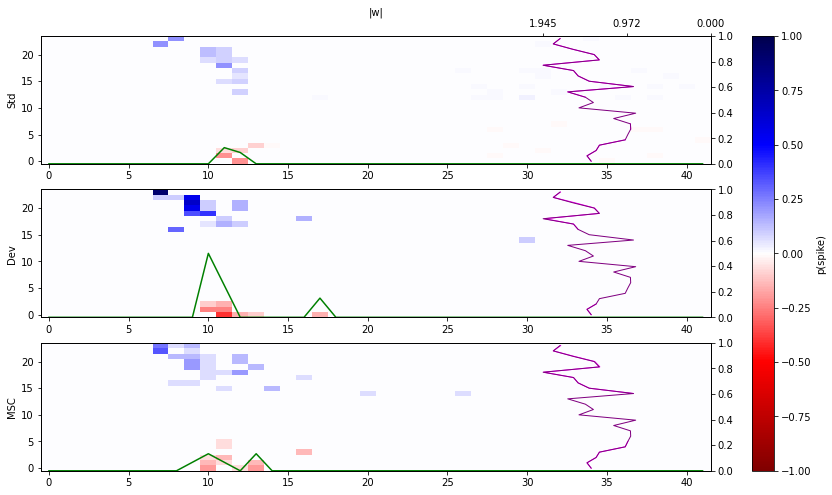

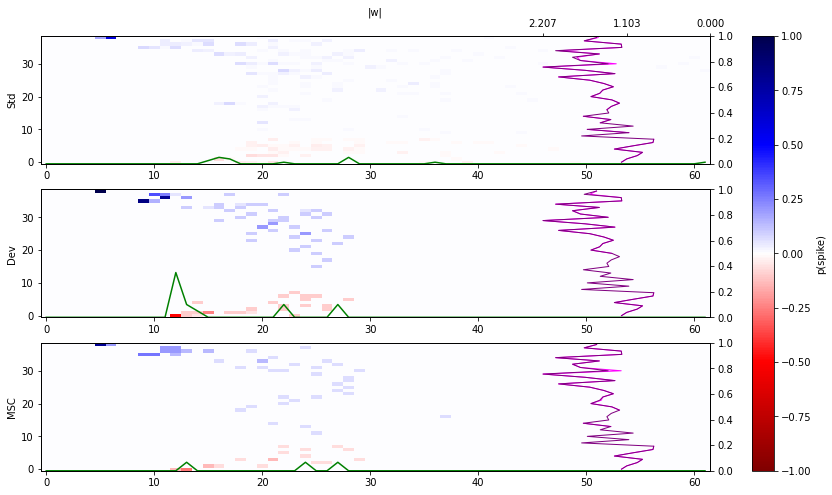

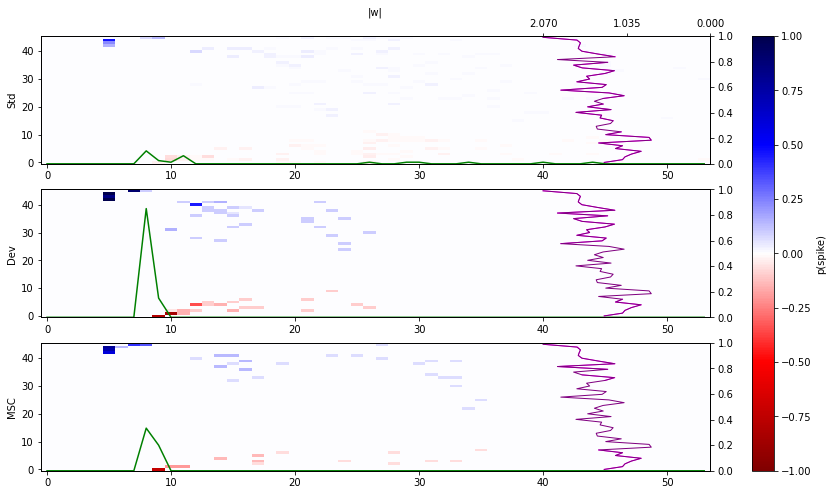

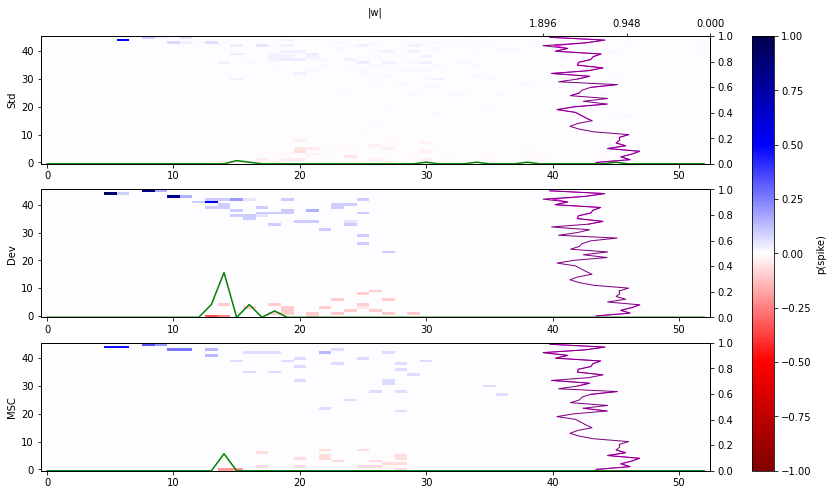

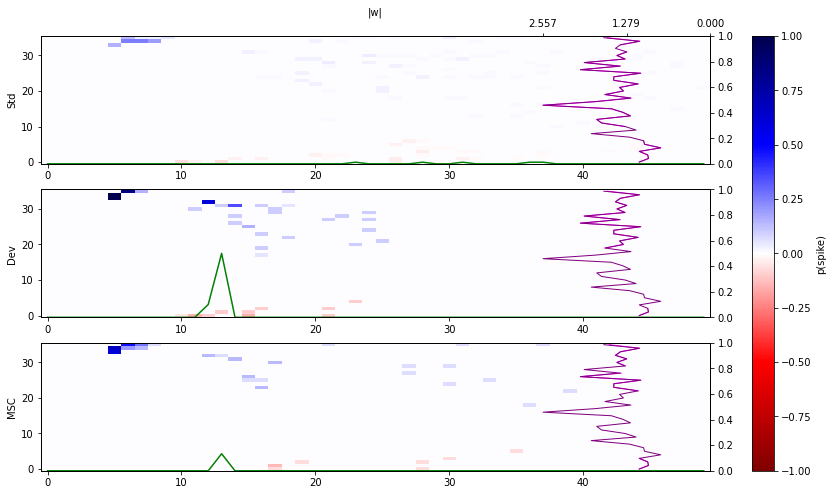

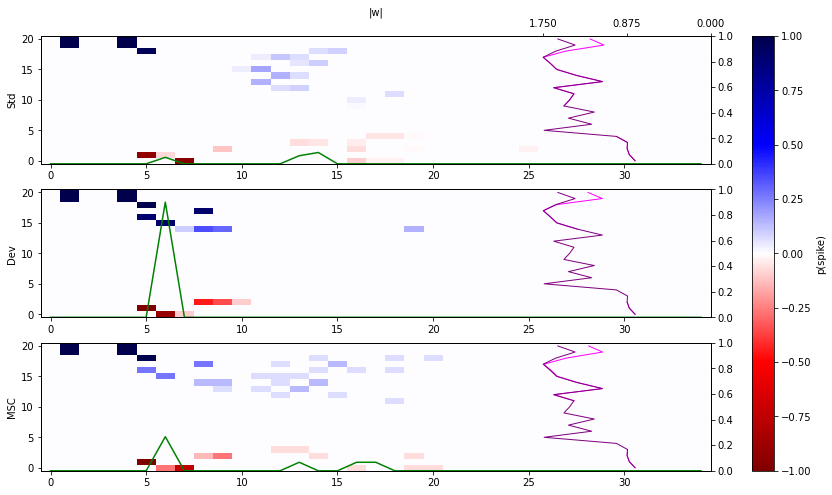

In [296]:
for i in np.argsort(all_results['A']['dev']['nspikes'] - all_results['A']['msc']['nspikes'])[-1:-10:-1]:
    plot_events(W, params, {k:v for k,v in all_results['A'].items() if k in ('Std', 'MSC', 'Dev')}, i, A, figsize=(15,8))

In [239]:
j = spatial.get_stimulated(X, Y, Xstim, Ystim, params)
j[A], j[B], i, np.flatnonzero(~np.isnan(W[:, i]))

(array([134, 231, 449, 842, 381, 947, 371, 677, 180, 990]),
 array([288, 606, 506, 984, 907,   5, 937, 747, 855, 236]),
 513,
 array([ 71, 121, 163, 180, 250, 277, 315, 342, 381, 400, 550, 591, 623,
        631, 694, 711, 803, 809, 897, 932, 964]))

In [247]:
np.flatnonzero(~np.isnan(W[:, 180])), np.flatnonzero(~np.isnan(W[:, 381]))

(array([ 11,  71, 168, 219, 269, 286, 301, 342, 345, 389, 419, 461, 477,
        549, 554, 677, 687, 699, 703, 713, 756, 765, 767, 803, 809, 842,
        947, 964, 990]),
 array([  7,  11,  14, 177, 193, 206, 229, 286, 312, 345, 385, 418, 419,
        462, 497, 501, 549, 604, 634, 649, 688, 691, 724, 739, 743, 751,
        756, 778, 794, 803, 808, 813, 842, 865, 884, 929, 942, 947, 949,
        958, 973, 981, 990]))

WARNING    /tmp/ipykernel_887733/1522901280.py:39: RuntimeWarning: invalid value encountered in true_divide
  ax3.plot(weights[order] * source_xrs[i, order]/source_hists[i, order].sum(1), np.arange(len(sources)), c='magenta', lw=1)
 [py.warnings]


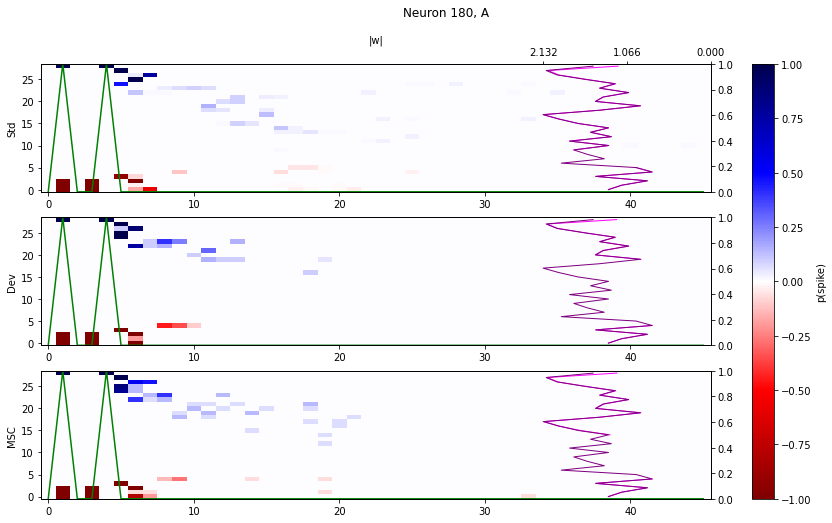

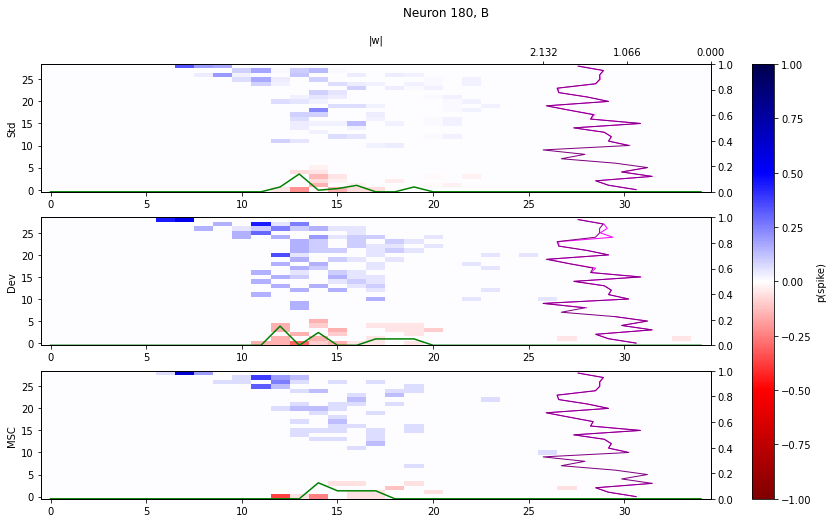

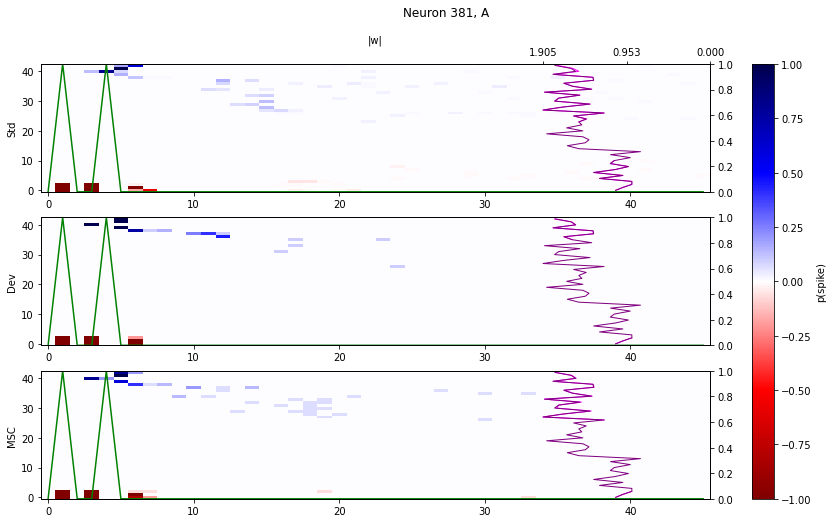

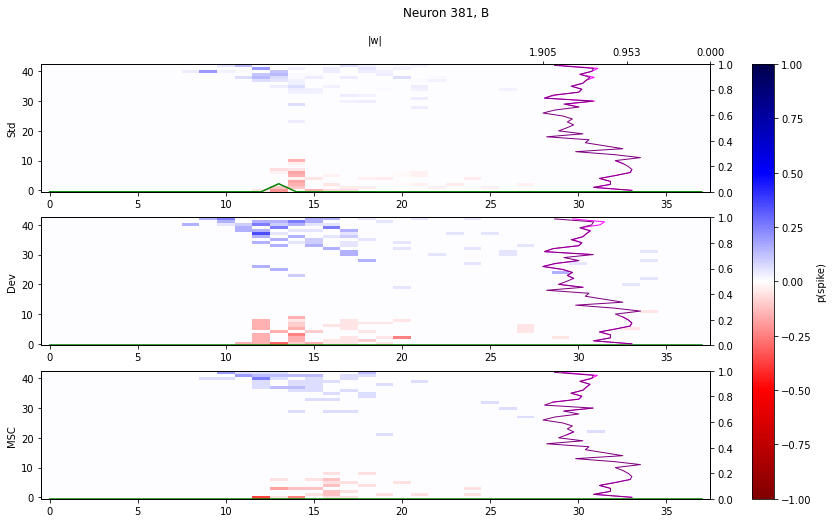

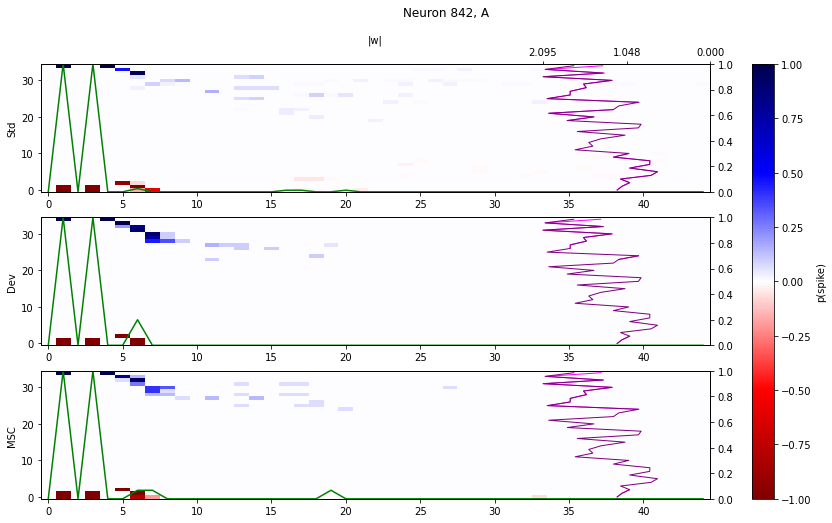

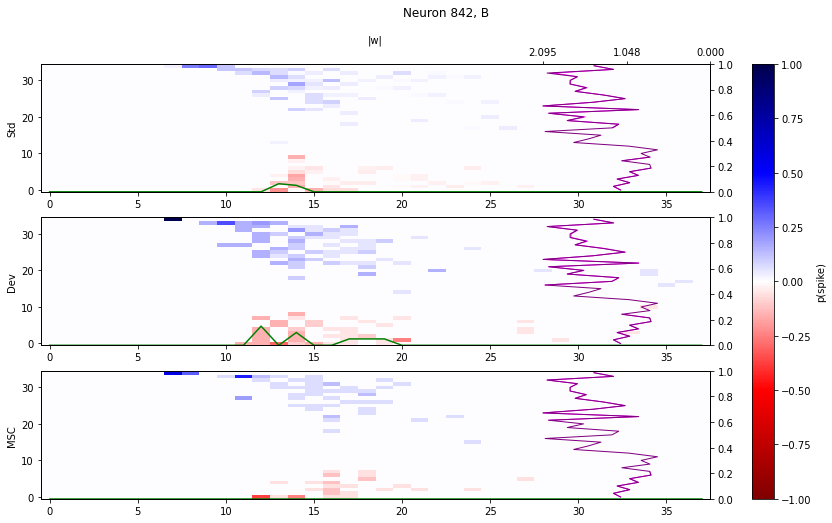

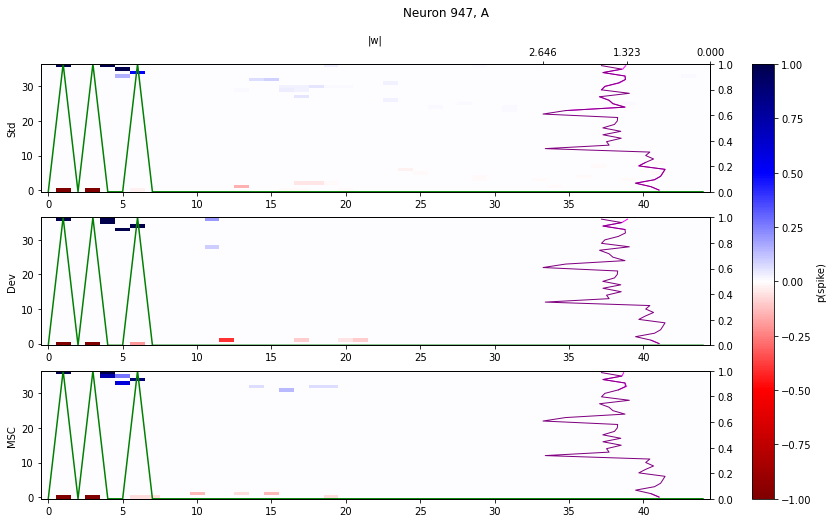

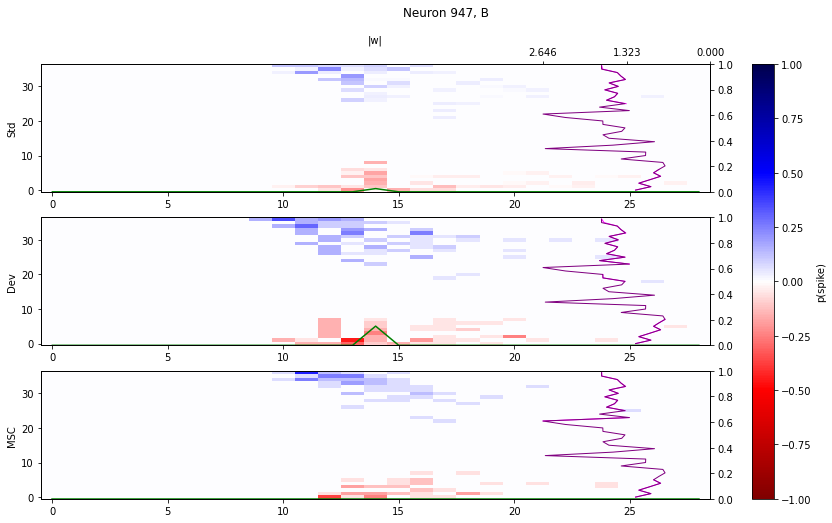

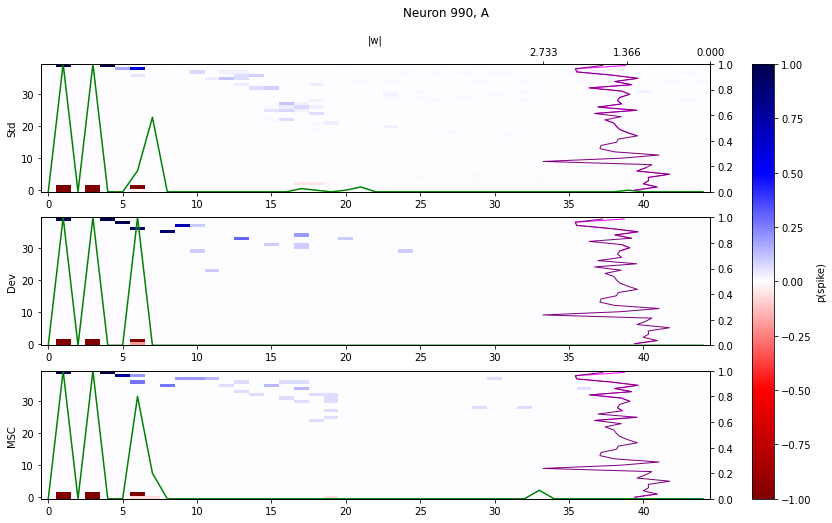

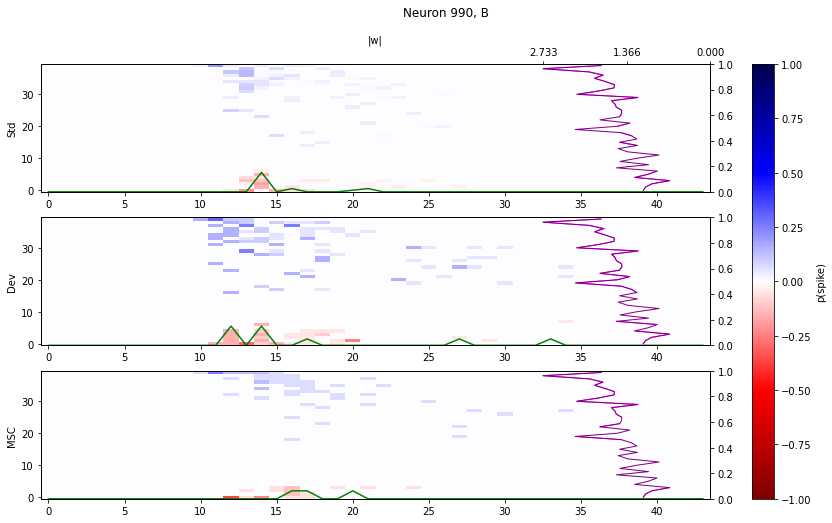

In [297]:
for idx in (180, 381, 842, 947, 990):
    for target in ('A', 'B'):
        plot_events(W, params, {k:v for k,v in all_results[target].items() if k in ('Std', 'MSC', 'Dev')}, idx, all_results[target]['stimulus'], figsize=(15,8))
        plt.suptitle(f'Neuron {idx}, {target}')

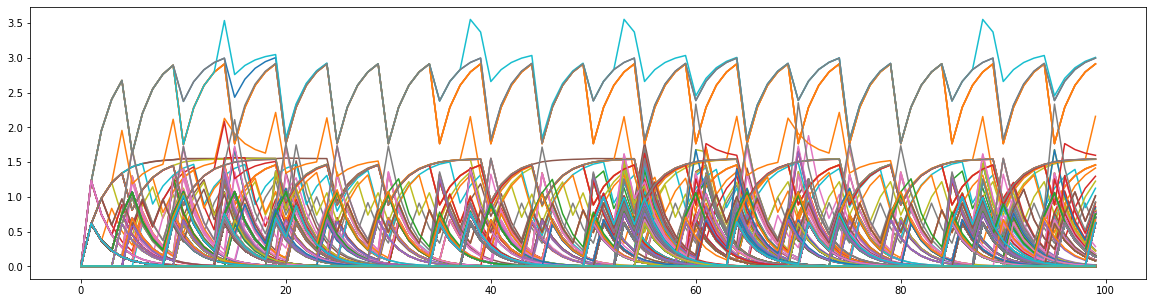

In [371]:
plt.figure(figsize=(20,5))
plt.plot(all_results['A']['Std']['pulse_onset_th_adapt']/mV);